# 06 - FWI with total variation (TV) minimization as constraints

## Introduction

There is a lot of research on regularization to improve the quality of the final result beyond the simple box constraints implemented in the previous tutorials. In this tutorial we look at how more advanced FWI techniques such as [total variation denoising]( https://en.wikipedia.org/wiki/Total_variation_denoising) applied as a constraint can be implemented using [Devito](http://www.opesci.org/devito-public) and [scipy.optimize.minimize](https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.minimize.html) using [scikit-image](http://scikit-image.org/). This is a variant of the FWI with TV constrains algorithm described in [Peters and Herrmann 2017](https://doi.org/10.1190/tle36010094.1).

[Dask](https://dask.pydata.org/en/latest/#dask) is also used here to speed up the examples.

This tutorial uses the same synthetic datasets and model setup as the previous two tutorials, so check back if you get lost on parts of the code specific to Devito, SciPy.optimize or Dask. 

## Setting up (synthetic) data
We are going to set up the same synthetic test case as for the previous tutorial (refer back for details).

In [1]:
#NBVAL_IGNORE_OUTPUT
from examples.seismic import Model, demo_model

# Define the grid parameters
def get_grid():
    shape = (101, 101)    # Number of grid point (nx, nz)
    spacing = (10., 10.)  # Grid spacing in m. The domain size is now 1km by 1km
    origin = (0., 0.)     # Need origin to define relative source and receiver locations

    return shape, spacing, origin

# Define the test phantom; in this case we are using a simple circle
# so we can easily see what is going on.
def get_true_model():
    shape, spacing, origin = get_grid()
    return demo_model('circle-isotropic', vp=3.0, vp_background=2.5, 
                      origin=origin, shape=shape, spacing=spacing, nbpml=40)

# The initial guess for the subsurface model.
def get_initial_model():
    shape, spacing, origin = get_grid()

    return demo_model('circle-isotropic', vp=2.5, vp_background=2.5, 
                      origin=origin, shape=shape, spacing=spacing, nbpml=40)


from examples.seismic.acoustic import AcousticWaveSolver
from examples.seismic import RickerSource, Receiver

# This is used by the worker to get the current model. 
def get_current_model(param):
    """ Returns the current model.
    """
    model = get_initial_model()
    model.m.data[:] = np.reshape(np.load(param['model']), model.m.data.shape)
    return model

# Inversion crime alert! Here the worker is creating the 'observed' data
# using the real model. For a real case the worker would be reading
# seismic data from disk.
def get_data(param):
    """ Returns source and receiver data for a single shot labeled 'shot_id'.
    """
    true_model = get_true_model()
    dt = true_model.critical_dt  # Time step from model grid spacing

    # Set up source data and geometry.
    nt = int(1 + (param['tn']-param['t0']) / dt)  # Discrete time axis length

    src = RickerSource(name='src', grid=true_model.grid, f0=param['f0'],
                       time=np.linspace(param['t0'], param['tn'], nt))
    src.coordinates.data[0, :] = [30, param['shot_id']*1000./(param['nshots']-1)]

    # Set up receiver data and geometry.
    nreceivers = 101  # Number of receiver locations per shot
    rec = Receiver(name='rec', grid=true_model.grid, npoint=nreceivers, ntime=nt)
    rec.coordinates.data[:, 1] = np.linspace(0, true_model.domain_size[0], num=nreceivers)
    rec.coordinates.data[:, 0] = 980. # 20m from the right end

    # Set up solver - using model_in so that we have the same dt,
    # otherwise we should use pandas to resample the time series data. 
    solver = AcousticWaveSolver(true_model, src, rec, space_order=4)

    # Generate synthetic receiver data from true model
    true_d, _, _ = solver.forward(src=src, m=true_model.m)

    return src, true_d, nt, solver

# Define a type to store the functional and gradient.
class fg_pair:
    def __init__(self, f, g):
        self.f = f
        self.g = g
    
    def __add__(self, other):
        f = self.f + other.f
        g = self.g + other.g
        
        return fg_pair(f, g)
    
    def __radd__(self, other):
        if other == 0:
            return self
        else:
            return self.__add__(other)

from devito import Function, clear_cache

# Create FWI gradient kernel for a single shot
def fwi_gradient_i(param):
    # Need to clear the workers cache.
    clear_cache()

    # Communicating the model via a file.
    model0 = get_current_model(param)
    src, rec, nt, solver = get_data(param)
    
    # Create symbols to hold the gradient and the misfit between
    # the 'measured' and simulated data.
    grad = Function(name="grad", grid=model0.grid)
    residual = Receiver(name='rec', grid=model0.grid, ntime=nt, coordinates=rec.coordinates.data)
    
    # Compute simulated data and full forward wavefield u0
    d, u0, _ = solver.forward(src=src, m=model0.m, save=True)
        
    # Compute the data misfit (residual) and objective function  
    residual.data[:] = d.data[:] - rec.data[:]
    f = .5*np.linalg.norm(residual.data.flatten())**2
    
    # Compute gradient using the adjoint-state method. Note, this
    # backpropagates the data misfit through the model.
    solver.gradient(rec=residual, u=u0, m=model0.m, grad=grad)
    
    # Copying here to avoid a (probably overzealous) destructor deleting
    # the gradient before Dask has had a chance to communicate it.
    g = np.array(grad.data[:])
    
    # return the objective functional and gradient.
    return fg_pair(f, g)

import numpy as np
from distributed import Client

# Dumps the model to disk; workers will pick this up when they need it.
def dump_model(param, model):
    np.save(param['model'], model.astype(np.float32))

def fwi_gradient(model, param):
    # Dump a copy of the current model for the workers
    # to pick up when they are ready.
    param['model'] = "model_0.npy"
    dump_model(param, model)

    # Define work list
    work = [dict(param) for i in range(param['nshots'])]
    for i in  range(param['nshots']):
        work[i]['shot_id'] = i
        
    # Start dask cluster
    client = Client()
    
    # Distribute worklist to workers.
    fgi = client.map(fwi_gradient_i, work)
    
    # Perform data reduction.
    fg = client.submit(sum, fgi).result()
    
    # Shutdown cluster
    client.close()
    
    # L-BFGS in scipy expects a flat array in 64-bit floats.
    return fg.f, fg.g.flatten().astype(np.float64)

## FWI with L-BFGS-B
Equipped with a function to calculate the functional and gradient, we are finally ready to define the optimization function.

In [2]:
from scipy import optimize
from skimage.restoration import denoise_tv_chambolle as denoise

# Define bounding box constraints on the solution.
def apply_box_constraint(m):
    # Maximum possible 'realistic' velocity is 3.5 km/sec
    # Minimum possible 'realistic' velocity is 2 km/sec
    return np.clip(m, 1/3.5**2, 1/2**2)

# Many optimization methods in scipy.optimize.minimize accept a callback
# function that can operate on the solution after every iteration. Here
# we use this to apply constraints and to monitor the true relative
# solution error.
relative_error = []

def fwi_tv_callbacks(x):
    # Apply boundary constraint
    x.data[:] = denoise(x.reshape(181, 181), weight=5.0e-3).flatten()
    x.data[:] = apply_box_constraint(x)
    
    # Calculate true relative error
    true_x = get_true_model().m.data.flatten()
    relative_error.append(np.linalg.norm((x-true_x)/true_x))

def fwi(model, param, ftol=1e-6, maxiter=20):
    result = optimize.minimize(fwi_gradient,
                               model.m.data.flatten().astype(np.float64),
                               args=(param, ), method='L-BFGS-B', jac=True,
                               callback=fwi_tv_callbacks,
                               options={'ftol':ftol,
                                        'maxiter':maxiter,
                                        'disp':True})

    return result

We now apply our FWI function and have a look at the result.

In [3]:
#NBVAL_SKIP

# Change to the WARNING log level to reduce log output
# as compared to the default DEBUG
from devito import configuration
configuration['log_level'] = 'WARNING'

# Set up inversion parameters.
param = {'t0': 0.,
         'tn': 1000.,              # Simulation lasts 1 second (1000 ms)
         'f0': 0.010,              # Source peak frequency is 10Hz (0.010 kHz)
         'nshots': 16}             # Number of shots to create gradient from

model0 = get_initial_model()

# Apply FWI with TV.
result = fwi(model0, param, ftol=1e-6, maxiter=100)

# Print out results of optimizer.
print(result)

      fun: 225.78709341897513
 hess_inv: <32761x32761 LbfgsInvHessProduct with dtype=float64>
      jac: array([ 0.,  0.,  0., ...,  0.,  0.,  0.])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 18
      nit: 9
   status: 0
  success: True
        x: array([ 0.16000003,  0.16000003,  0.16000003, ...,  0.16000003,
        0.16000002,  0.16000002])


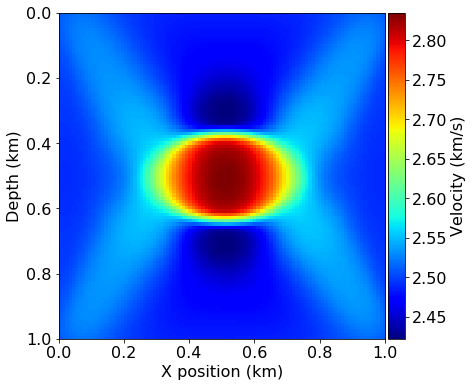

In [4]:
#NBVAL_SKIP

# Show what the update does to the model
from examples.seismic import plot_image, plot_velocity

model0.m.data[:] = result.x.astype(np.float32).reshape(model0.m.data.shape)
model0.vp = np.sqrt(1. / model0.m.data[40:-40, 40:-40])
plot_velocity(model0)

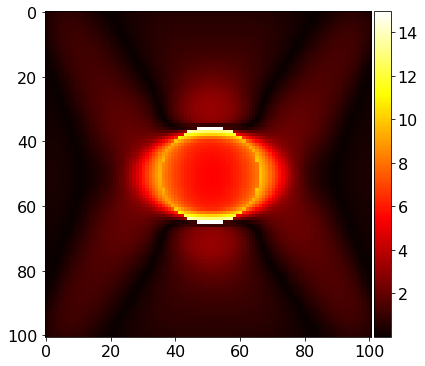

In [5]:
#NBVAL_SKIP

# Plot percentage error
plot_image(100*np.abs(model0.vp-get_true_model().vp.data)/get_true_model().vp.data, vmax=15, cmap="hot")

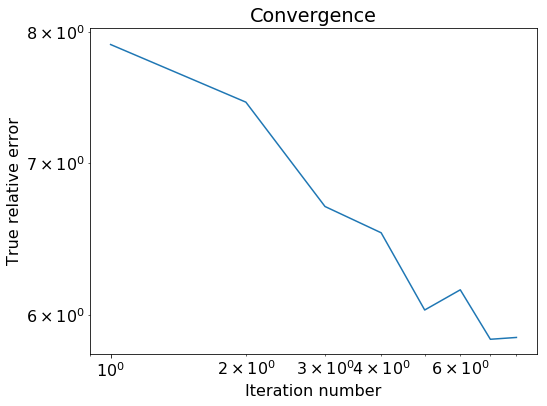

In [6]:
#NBVAL_SKIP
import matplotlib.pyplot as plt

# Plot objective function decrease
plt.figure()
plt.loglog(relative_error)
plt.xlabel('Iteration number')
plt.ylabel('True relative error')
plt.title('Convergence')
plt.show()

<sup>This notebook is part of the tutorial "Optimised Symbolic Finite Difference Computation with Devito" presented at the Intel® HPC Developer Conference 2017.</sup>